In [269]:
import pandas as pd

In [270]:
df = pd.read_excel('../../data_set/monthlyInvestigation/cleaned_monthly_investigations.xlsx')

In [279]:
df.sort_values(['Subject_ID', 'Month'], inplace=True)

# Create the target variable by shifting Hb column backward by 1 month for each patient
df['Next_Hb'] = df.groupby('Subject_ID')['Hb (g/dL)'].shift(-1)
df['Hb_diff'] = df['Hb (g/dL)'] - df.groupby('Subject_ID')['Hb (g/dL)'].shift(1)


# Define 3-class risk label:
# 0 = Safe (10 ≤ Hb ≤ 12)
# 1 = Risk (Hb < 10)
# 2 = Risk (Hb > 12)
# df['Risk_Label'] = df['Next_Hb'].apply(
#     lambda x: 1 if x < 10 else (2 if x > 12 else 0)
# )
df['Risk_Label'] = df['Next_Hb'].apply(lambda x: 1 if x < 10 or x > 12 else 0)


df = df.dropna(subset=['Next_Hb', 'Risk_Label', 'Hb_diff'])

In [280]:
df

,Subject_ID,Month,Albumin (g/L),BU - post HD,BU - pre HD,Hb (g/dL),S Ca (mmol/L),SCR- post HD (µmol/L),SCR- pre HD (µmol/L),Serum K Post-HD (mmol/L),Serum K Pre-HD (mmol/L),Serum Na Pre-HD (mmol/L),UA (mg/dL),Next_Hb,Hb_diff,Risk_Label
1,RHD_THP_001,2024-02-01,37.7,0.38,14.14,13.1,2.23,97.37,513.60,2.90,4.32,136.0,408.0,12.8,2.1,1
2,RHD_THP_001,2024-03-01,40.6,5.85,12.30,12.8,2.24,276.00,560.00,3.90,4.75,141.4,404.0,12.2,-0.3,1
3,RHD_THP_001,2024-04-01,35.8,6.30,18.90,12.2,1.97,325.40,689.00,4.40,4.20,138.4,487.0,12.9,-0.6,1
4,RHD_THP_001,2024-05-01,36.9,6.75,14.79,12.9,2.53,374.80,601.93,4.90,3.80,138.2,336.0,13.3,0.7,1
5,RHD_THP_001,2024-06-01,34.5,0.48,17.40,13.3,2.14,118.61,610.25,2.50,4.40,140.8,408.0,14.2,0.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,RHD_THP_044,2024-10-01,36.1,4.10,16.90,12.2,2.10,344.00,1145.00,2.38,5.09,139.0,371.0,12.6,-0.4,1
393,RHD_THP_045,2024-07-01,31.4,3.54,10.20,8.8,2.30,212.00,398.00,2.80,3.91,135.0,385.0,9.6,-0.5,1
394,RHD_THP_045,2024-08-01,31.4,3.70,8.29,9.6,2.30,162.00,402.50,3.13,3.78,134.6,365.0,10.5,0.8,0
395,RHD_THP_045,2024-09-01,32.6,0.27,11.37,10.5,2.54,63.80,466.00,2.36,4.20,134.0,345.0,11.3,0.9,0


In [281]:
feature_cols = [
    'Albumin (g/L)', 'BU - post HD', 'BU - pre HD', 'S Ca (mmol/L)',
    'SCR- post HD (µmol/L)', 'SCR- pre HD (µmol/L)',
    'Serum K Post-HD (mmol/L)', 'Serum K Pre-HD (mmol/L)',
    'Serum Na Pre-HD (mmol/L)', 'UA (mg/dL)', 'Hb (g/dL)', 'Hb_diff'
]

In [282]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['Subject_ID']))

X_train = df.iloc[train_idx][feature_cols]
y_train = df.iloc[train_idx]['Risk_Label']

X_test = df.iloc[test_idx][feature_cols]
y_test = df.iloc[test_idx]['Risk_Label']

In [ ]:
y_train.value_counts(), y_test.value_counts()a

(Risk_Label
 1    97
 0    78
 Name: count, dtype: int64,
 Risk_Label
 1    73
 0    28
 Name: count, dtype: int64)

In [284]:
# from imblearn.over_sampling import SMOTE
# from collections import Counter

# # Apply SMOTE
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# # Print class distribution after SMOTE
# print("Class distribution after SMOTE:", Counter(y_train))

In [285]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(random_state=42, class_weight='balanced', min_samples_split=3,n_estimators=100, max_depth=100, min_samples_leaf=1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[12 16]
 [21 52]]
              precision    recall  f1-score   support

           0       0.36      0.43      0.39        28
           1       0.76      0.71      0.74        73

    accuracy                           0.63       101
   macro avg       0.56      0.57      0.57       101
weighted avg       0.65      0.63      0.64       101



Accuracy: 0.69
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.43      0.44        28
           1       0.78      0.79      0.79        73

    accuracy                           0.69       101
   macro avg       0.61      0.61      0.61       101
weighted avg       0.69      0.69      0.69       101



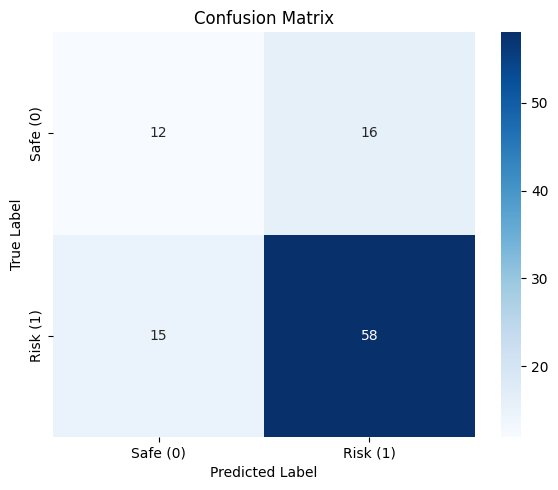

In [287]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    
}

search = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=7,
    scoring='f1_macro',
    random_state=42
)

search.fit(X_train, y_train)
best_model = search.best_estimator_

best_model

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test data
y_pred = best_model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Safe (0)', 'Risk (1)'],
            yticklabels=['Safe (0)', 'Risk (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
